In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv("C:/Users/sg/Desktop/DTSBC-Kendi-notlarım/datasets/cookie_cats.csv")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


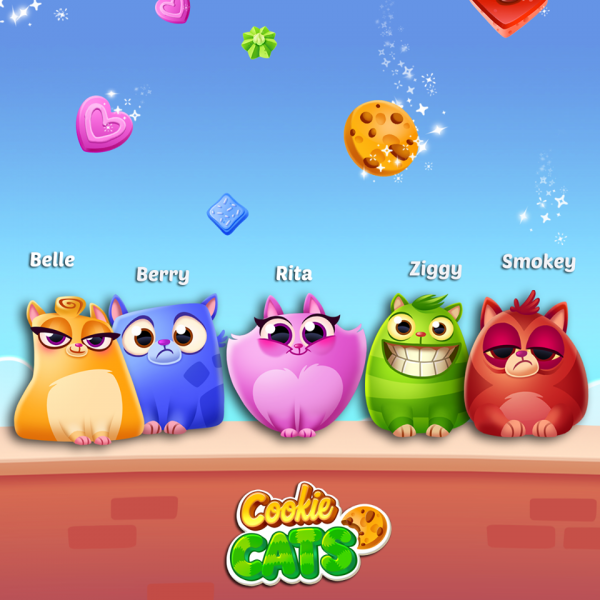

# Quick look to the data <a id="introduction"></a>

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. 
As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. 

# Data Exploration <a id="paragraph1"></a>

***userid:***  A unique number that identifies each player.

***version:*** Whether the player was put in gate_30 or gate_40

***sum_gamerounds:*** The number of game rounds played by the player during the first week after installation

***retention_1:*** Did the player come back and play 1 day after installing?

***retention_7:*** Did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40. In this project, I will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. 

In [3]:
#I write a function to summarize the general information about the dataset.
def check_df(dataframe, head=10):
    print('\033[1m' + 10*"*" + ' SHAPE ' + 10*"*" + '\033[0m')
    print(f"Rows:{dataframe.shape[0]}")
    print(f"Columns:{dataframe.shape[1]}")

    print('\033[1m' + 10*"*" + ' TYPES ' + 10*"*" + '\033[0m')
    print(dataframe.dtypes)

    print('\033[1m' + 10*"*" + ' HEAD ' + 10*"*" + '\033[0m')
    print(dataframe.head(head))

    print('\033[1m' + 10*"*" + ' TAIL ' + 10*"*" + '\033[0m')
    print(dataframe.tail(head))

    print('\033[1m' + 10*"*" + ' COLUMNS ' + 10*"*" + '\033[0m')
    print(dataframe.columns)

    print('\033[1m' + 10*"*" + ' NUNIQUE ELEMENTS ' + 10*"*" + '\033[0m')
    print(dataframe.nunique())
    print('\033[1m' + 10*"*" + ' NA ' + 10*"*" + '\033[0m')
    print(dataframe.isnull().sum())

    print('\033[1m' + 10*"*" + ' DESCRIBE ' + 10*"*" + '\033[0m')
    print(dataframe.describe().T)
    
check_df(df,10)

********** SHAPE **********
Rows:90189
Columns:5
********** TYPES **********
userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object
********** HEAD **********
   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
5     540  gate_40             187         True         True
6    1066  gate_30               0        False        False
7    1444  gate_40               2        False        False
8    1574  gate_40             108         True         True
9    1587  gate_40             153         True        False
********** TAIL **********
        userid  version  sum_gamerounds  retention_1  reten

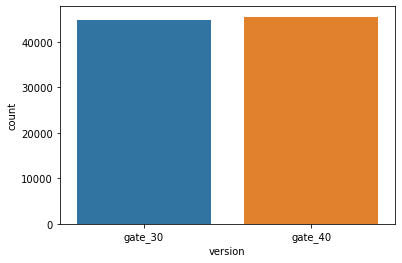

In [4]:
#Let's see the graph for better understanding.
df.groupby("version")["userid"].count()
sns.countplot(x="version",data=df);

In [5]:
df.groupby('version').agg({"sum_gamerounds": ["count", "mean"]}).reset_index()

version sum_gamerounds        
                    count    mean
0  gate_30          44700 52.4563
1  gate_40          45489 51.2988

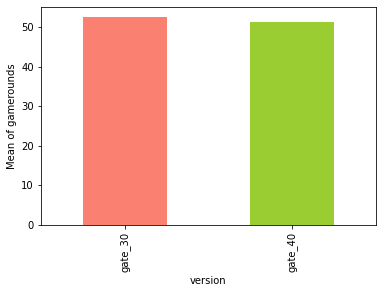

In [6]:
df.groupby("version")["sum_gamerounds"].mean()
df.groupby("version")["sum_gamerounds"].mean().plot(kind="bar", color=[ "salmon", "yellowgreen"]);

plt.ylabel("Mean of gamerounds");

# Outliers <a id="paragraph2"></a>

#### Generally if I have an outliers value in dataset, the right move should be removing these values because it affects the statistical calculations.

In [7]:
#Before the outlier value
df.sum_gamerounds.describe()

count   90189.0000
mean       51.8725
std       195.0509
min         0.0000
25%         5.0000
50%        16.0000
75%        51.0000
max     49854.0000
Name: sum_gamerounds, dtype: float64

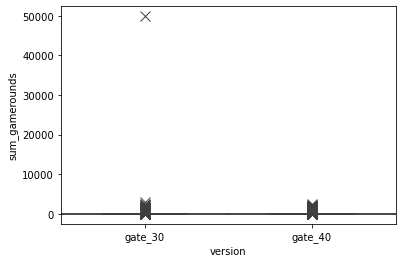

In [8]:
#There is outlier value in "gate_30".
sns.boxplot(data=df, x="version", y="sum_gamerounds", flierprops={"marker": "x"}, width=1.0, fliersize=10);

In [9]:
# I write a function to get rid of the outlier values.
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [10]:
replace_with_thresholds(df, "sum_gamerounds")

In [11]:
#After  removing the outlier value
df.sum_gamerounds.describe()

count   90189.0000
mean       51.1092
std        99.3123
min         0.0000
25%         5.0000
50%        16.0000
75%        51.0000
max      1232.5000
Name: sum_gamerounds, dtype: float64

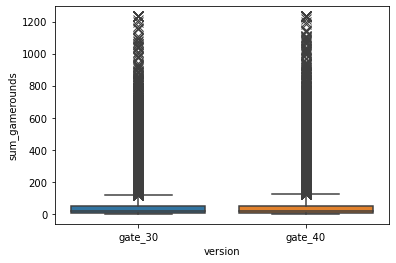

In [12]:
#I saw more logical graph.
sns.boxplot(data=df, x="version", y="sum_gamerounds", flierprops={"marker": "x"}, width=0.8, fliersize=10);


# A/B Testing <a id="paragraph3"></a>

## 1.Establish the Hypothesis

* H0: M1 = M2 
* H1: M1 != M2

***In this case,***

***H0: M1 = M2 --- There is no statistical difference between the gate_30 and the gate_40.***

***H1: M1 != M2 ---- There is statistical difference between the gate_30 and the gate_40.***

## 2. Assumption Check
* It may be helpful to perform outlier analysis and correction before testing for normality.

***Normality Assumption (Shapiro Test)***
* H0: Distribution is Normal
* H1: Distribution is not Normal

***p-value check***
* p-value < 0.05 : H0 is rejected
* p-value > 0.05 : H0 can't rejected

***Variance Homogeneity (Levene Test)***
* H0: Variance is homogeneous
* H1: Variance is not homogeneous

## 3. Implementation of the Hypothesis

* If the distribution is Normal and the variances are Homogeneous; apply the T-Test (parametric test)
* If the distribution is Normal and the variances are not Homogeneous; apply Welch Test 
* If the distribution is not Normal; apply Mann Whitney U Test directly (non-parametric test)

## 4.Interpret results based on p-value and evaluate the the Hypothesis

* p-value < 0.05 : H0 is rejected
* p-value > 0.05 : H0 can't rejected

In [13]:
def AB_Test(df, pthres=0.05):
    
    # H0:  There is no statistical difference between the gate_30 and the gate_40.
    
    print(df.groupby('version').agg({"sum_gamerounds": ["count", "mean"]}))

    print("NORMAL DISTRIBUTION ASSUMPTION" .center(70,"*"))
    
    # H0 : The compared groups have a normal distribution
    
    pvalue_gate_30 = shapiro([df["version"] == "gate_30"])[1]
    pvalue_gate_40 = shapiro([df["version"] == "gate_40"])[1]
    
    print('p-value_gate30 = %.5f' % (pvalue_gate_30))
    print('p-value_gate40 = %.5f' % (pvalue_gate_40))

    if (pvalue_gate_30 < pthres) & (pvalue_gate_40 < pthres):
        print("Normality H0 is rejected.\n\n")
    else:
        print("Normality H0 is not rejected.\n")

    print("VARIANCE HOMOGENEOUS ASSUMPTION ".center(70,"*"))
    
    # H0 : The variance of compared groups is homegenous.
    
    p_value_levene = levene(df.loc[df["version"] == "gate_30", "sum_gamerounds"],
                            df.loc[df["version"] == "gate_40", "sum_gamerounds"])[1]
    
    print('p_value_levene = %.5f' % p_value_levene)

    if p_value_levene < pthres:
        print("Variance Homogeneity H0 is rejected.\n")
    else:
        print("Variance Homogeneity H0 is not rejected.\n")

    if ((pvalue_gate_30 > pthres) & (pvalue_gate_40 > pthres)) & (p_value_levene > pthres):
        p_value_ttest = ttest_ind(df.loc[df["version"] == "gate_30"],
                                  df.loc[df["version"] == "gate_40"],
                                  equal_var=True)[1]
        
        print('p_value_ttest = %.5f' % p_value_ttest)

    elif ((pvalue_gate_30 > pthres) & (pvalue_gate_40 > pthres)) & (p_value_levene < pthres):
        p_value_ttest = ttest_ind(df.loc[df["version"] == "gate_30"],
                                  df.loc[df["version"] == "gate_40"],
                                  equal_var=False)[1]
        
        print('p_value_ttest = %.5f' % p_value_ttest)
    else:
        print("Non-Parametric test should be done.\n\n")
        pvalue = mannwhitneyu(df.loc[df["version"] == "gate_30", "sum_gamerounds"],
                              df.loc[df["version"] == "gate_40", "sum_gamerounds"])[1]
        
        print('p_value = %.5f' % pvalue)

    print(" RESULT ".center(70,"*"))

    if pvalue < pthres:
        print(
            f"p-value {round(pvalue, 5)} < 0.05  H0 Hypothesis is Rejected. That is, there is a statistically significant difference between them.")

    else:
        print(
            f"p-value > {pthres} H0 is Not Rejected, That is, there is no statistically significant difference between them. The difference was made by chance.")
AB_Test(df,0.05)

        sum_gamerounds        
                 count    mean
version                       
gate_30          44700 51.1534
gate_40          45489 51.0658
********************NORMAL DISTRIBUTION ASSUMPTION********************
p-value_gate30 = 0.00000
p-value_gate40 = 0.00000
Normality H0 is rejected.


*******************VARIANCE HOMOGENEOUS ASSUMPTION *******************
p_value_levene = 0.83018
Variance Homogeneity H0 is not rejected.

Non-Parametric test should be done.


p_value = 0.05021
******************************* RESULT *******************************
p-value > 0.05 H0 is Not Rejected, That is, there is no statistically significant difference between them. The difference was made by chance.


# Conclusion

* There is no statistically significant difference between the "gate_30" and the "gate_40". The difference was made by chance.
* Therefore, The company should keep using gate_30 because we have statistical evidence with 95% confidence.

### If you liked this notebook, please do upvote😊😊

### For more;

### https://www.linkedin.com/in/saliha-g%C3%B6rg%C3%BCl%C3%BC-9b5038203/

### https://github.com/salihagorgulu